In [17]:
import sys
sys.path.insert(0, "..")
import snscrape.modules.twitter as sntwitter
from fastapi.encoders import jsonable_encoder
import json
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import re
from config import conf
from utils import translate
from cleaner import Cleaner
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from cleaner import Cleaner
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [9]:
client = MongoClient(conf['mongo_uri'])
db = client.politweet
tweets = list(db.tweets.find({"retweetedTweet":False, "quotedTweet":False}, {"_id":0, "content":1, "group":1, "date":1}))
party_tweets = list(db.party_tweets.find({"retweetedTweet":False, "quotedTweet":False}, {"_id":0, "content":1, "group":1, "date":1}))

In [10]:
tweets = tweets + party_tweets

In [11]:
def get_target(group, target_dict=None):
    '''
    Takes the political group as an argument
    Returns 'droite' or 'gauche'
    Else returns 'inconnu' e.g. if it is a group of the center
    '''
    if target_dict is None:
      target_dict = {
        "droite":["DLF", "LDS", "LR", "RN"],
        "gauche":["FI", "GDR", "LND", "SOC"],
      }
    if group in target_dict["droite"]:
      return "droite"
    elif group in target_dict["gauche"]:
      return "gauche"
    else:
      return "centre"


df = pd.DataFrame(tweets)
# cleaner = Cleaner(df, base_pipeline=["userhandles", "hashtags"])
# soft_pipeline = ["emoji", "numbers", "dates", "non_asci", "fr_stopwords", "multiple_spaces"]
# cleaner = Cleaner(df)
# cleaner.clean(pipeline=["emoji", "numbers", "dates", "non_asci", "fr_stopwords", "multiple_spaces"])
def clean(txt):
    from bs4 import BeautifulSoup #Nettoyage d'HTML
    import nltk
    import unicodedata

    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    txt = txt.lower()
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    txt = re.sub('[^a-z_]', ' ', txt)
    french_stopwords = nltk.corpus.stopwords.words('french')
    stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in french_stopwords]
    tokens = [w for w in txt.split() if (w not in stopwords)]
    stemmer=nltk.stem.SnowballStemmer('french')
    tokens_stem = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens_stem)

# df['content'] = df.content.apply(lambda x: clean(x))
# df = cleaner.input
df['target'] = df.group.apply(get_target)
df = df.query("target!='centre'")
# df['target'] = df['group']
df.target.value_counts()


gauche    57582
droite    51813
Name: target, dtype: int64

In [4]:
# df = cleaner.input
# df['target'] = df.group.apply(get_target)
# df = df.query("target!='centre'")
# df.target.value_counts()

# import texthero as hero
# df.content = hero.preprocessing.stem(df.content, stem='snowball', language='french')

In [8]:
def test_target(group):
    base = {"droite" : ["AGIR-E","UDI_I"], "gauche" : ["EDS", "GE"]}
    if group in base["droite"]:
        return 0
    elif group in base["gauche"]:
        return 1
    else:
        return -1

test_df = pd.DataFrame(tweets)
test_df['target'] = test_df.group.apply(test_target)
test_df = test_df.query("target >= 0")
test_df
test_X = test_df.content
test_y = test_df.target

test_X_tf = tfidf.transform(test_X)
y_pred = model.predict(test_X_tf)
print('Accuracy Score - {}'.format(accuracy_score(test_y, y_pred)))
print('Recall Score (macro) - {}'.format(recall_score(test_y, y_pred,average='macro')))

NameError: name 'tfidf' is not defined

In [14]:
def balance_class(df, field):
  min_size = df[field].value_counts().values.min()
  return df.groupby(field).apply(lambda x: x.sample(min_size)).reset_index(drop=True)

def encode_target(target):
    if target == "droite":
        return 0
    else:
        return 1

df.target = df.target.apply(encode_target)
df = balance_class(df, 'target')
df.target.value_counts()

0    51813
1    51813
Name: target, dtype: int64

In [15]:
df

,group,date,content,target
0,RN,2021-06-08 13:32:23,Retrouvez-moi à 16h45 sur @WEO_TV ! https://t....,0
1,LR,2020-12-14 18:26:34,Belle initiative cet après-midi avec le lancem...,0
2,LR,2019-08-24 11:25:18,Ce matin à l’inauguration des traditionnelles ...,0
3,LR,2020-07-21 14:39:50,🛹 Le SkatePark à #Itancourt c’est pour bientôt...,0
4,LR,2021-02-18 19:59:02,Tout mon soutien à @YaelBRAUNPIVET qui fait à ...,0
...,...,...,...,...
103621,FI,2021-03-21 20:22:55,"Syndicaliste de la @ConfPaysanne, notre ami La...",1
103622,FI,2020-01-01 17:44:51,Jeudi 2 janvier je serai à partir de 5 h au dé...,1
103623,FI,2020-01-29 14:51:54,"J'apporte tout mon soutien à Patrick, postier ...",1
103624,SOC,2020-08-06 15:40:08,@franceinter @HazizaEmma Tout est dit ! Je sui...,1


Accuracy Score - 0.8377830674215131
Recall Score (macro) - 0.8377830674215131
Figure(1440x1440)
Model Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84     15544
           1       0.84      0.84      0.84     15544

    accuracy                           0.84     31088
   macro avg       0.84      0.84      0.84     31088
weighted avg       0.84      0.84      0.84     31088



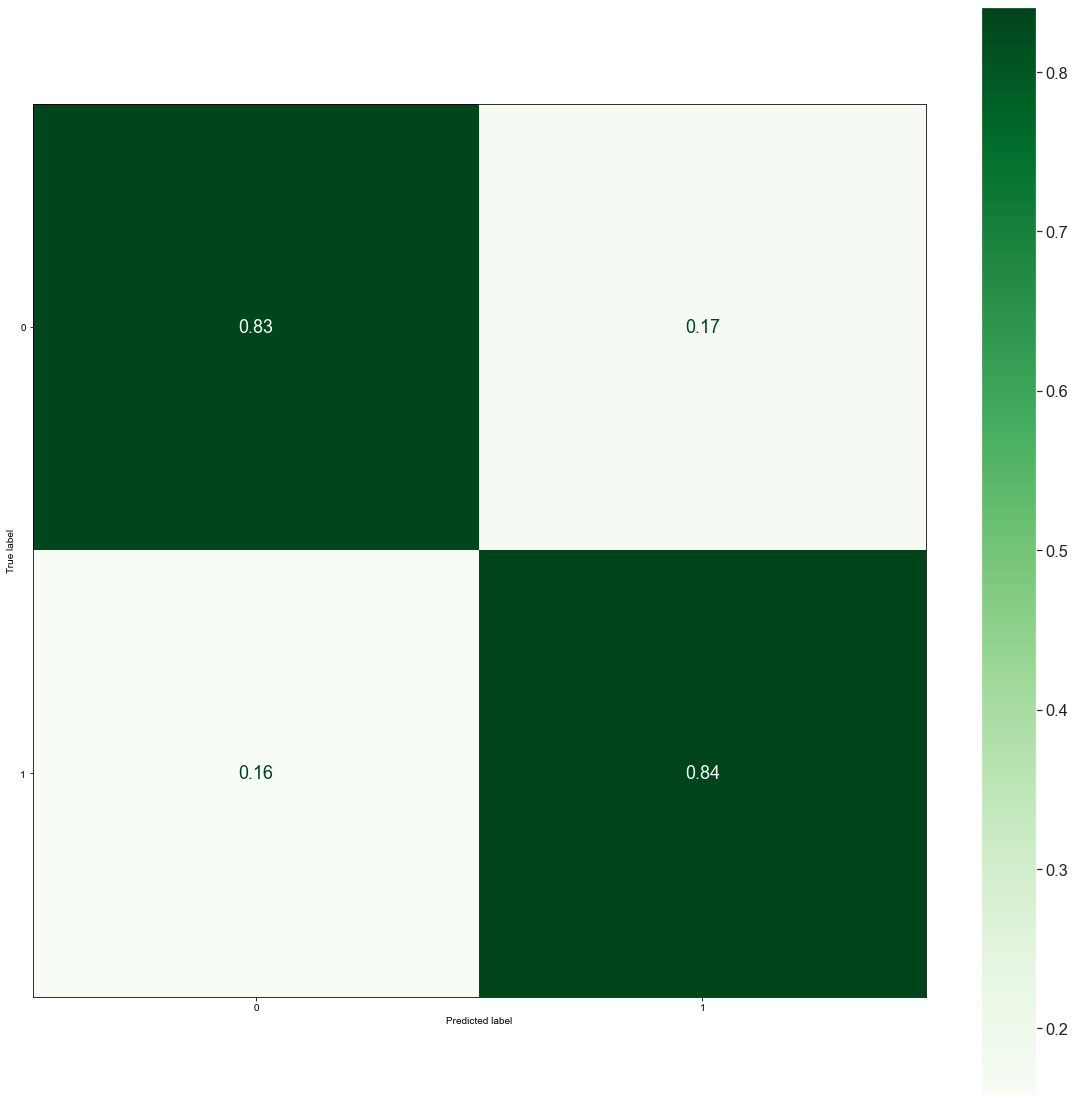

In [18]:


ml = df.copy()
X = ml.content
y = ml.target
model=LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2))
X_train_tf = tfidf.fit_transform(X_train)
model.fit(X_train_tf, y_train)
X_test_tf = tfidf.transform(X_test)
y_pred = model.predict(X_test_tf)
print('Accuracy Score - {}'.format(accuracy_score(y_test, y_pred)))
print('Recall Score (macro) - {}'.format(recall_score(y_test, y_pred,average='macro')))
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)
plot_confusion_matrix(model,X_test_tf,
                    y_test,
                    normalize='true',
                    cmap=plt.cm.Greens,
                    ax=ax)
print(fig)
print('Model Report:\n ' + classification_report(y_test, y_pred))

In [ ]:
def predict_emotion(X,model):
    prediction = model.predict(X)
    return dict(zip(model.classes_, model.predict_proba(X)[0]))



In [25]:
input = "j'aime le café"
predictions = model.predict_proba(tfidf.transform([input]))
dump((tfidf, model), 'filename.joblib')
predictions

array([[0.72822148, 0.27177852]])

In [32]:
tfidf_clf, clf = load('model.joblib')
predictions = model.predict_proba(tfidf_clf.transform([input]))
type(list(predictions[0]))
predictions